In [1]:
import os 
import tensorflow 
from PIL import Image, ImageDraw
import math
import pandas as pd 
from tqdm import tqdm 


In [2]:
folder_sources = []
Orig_Dataset_path = "Segmented Herbal Leaf images"
New_Dataset_path = "Transformed"

for file in os.listdir(Orig_Dataset_path):
    folder_sources.append(file)
        
print(folder_sources)

['Momordica Charantia (Ampalaya)', 'Moringa Oleifera (Malunggay)', 'Psidium Guajava (Guava)', 'Vitex Negundo (Lagundi)']


In [3]:
for folder in folder_sources:
    f_ = os.path.join(New_Dataset_path, folder)
    if not os.path.exists(f_):
        os.mkdir(f_)
        print("Created Path:", f_)

In [4]:
# Degrees is in radians
def calculate_new_coords(degrees, x, y, iw, ih):
    res_x = iw / 2 + (x - iw / 2) * math.cos(degrees) + (y - ih / 2) * math.sin(degrees)
    res_y = ih / 2 - (x - iw / 2) * math.sin(degrees) + (y - ih / 2) * math.cos(degrees)
    return (res_x, res_y)

In [5]:
BASE_IMAGE_SIZE = ((100, 100))
BASE_CANVAS_SIZE = ((200, 200))
X_VARIATIONS = 5
Y_VARIATIONS = 5
ROTATION_VARIATION = 36
ROTATION_DEGREES = 360 / ROTATION_VARIATION
DRAW_BOUNDING_BOX = False
BORDER_WIDTH = 5 
BORDER_COLOR = "Blue"

In [6]:
for folder in tqdm(folder_sources):
    current_folder_dict = {
        "image_name" : [],
        "x0" : [],
        "y0" : [],
        "x1" : [],
        "y1" : [],
        "x2" : [],
        "y2" : [],
        "x3" : [],
        "y3" : [],
        "class" : []
    }

    for image in os.listdir(os.path.join(Orig_Dataset_path, folder)):

        current_image = Image.open(os.path.join(Orig_Dataset_path, folder, image))
        current_image.thumbnail(BASE_IMAGE_SIZE)
        
        x0, y0 = (0, 0)
        x1, y1 = current_image.size 
        iw, ih = current_image.size 
        
        # Rotate Image
        for i in range(ROTATION_VARIATION + 1):
            current_degrees = int(i * ROTATION_DEGREES)

            rotated_image = current_image.copy()
            rotated_image = rotated_image.rotate(current_degrees, expand=True)

            r_i_width, r_i_height = rotated_image.size

            original_bbox_coords = [(x0, y0), (x1, y0), (x1, y1), (x0, y1)]

            _degrees = math.radians(current_degrees)

            new_coords = []
            _x, _y = 0, 1
            
            for x, y in original_bbox_coords:
                __x, __y = calculate_new_coords(_degrees, x, y, iw, ih)
                _x = min(__x, _x)
                _y = max(__y, _y)
                new_coords.append((__x, __y))

            excess_x = 0 - _x 
            excess_y = r_i_height - _y
            
            final_bbox_coords = [(x + excess_x, y + excess_y) for x, y in new_coords]
                
            # Transposition
            c_w , c_h = BASE_CANVAS_SIZE

            x_steps = abs(r_i_width - c_w) / X_VARIATIONS
            y_steps = abs(r_i_height - c_h) / Y_VARIATIONS
            
            for y in range(Y_VARIATIONS + 1):
                for x in range(X_VARIATIONS + 1):
                    canvas = Image.new("RGB", BASE_CANVAS_SIZE)
                    x_movement, y_movement = int(x_steps) * x, int(y_steps) * y
                    canvas.paste(rotated_image, (x_movement, y_movement))
                    

                    transposed_bbox_coords = [(x + x_movement, y + y_movement) for x, y in final_bbox_coords]

                    if DRAW_BOUNDING_BOX:
                        _d = ImageDraw.Draw(canvas)
                        _d.polygon(transposed_bbox_coords, width=BORDER_WIDTH, outline=BORDER_COLOR)

                    #display(canvas)

                    c0, c1, c2, c3 = transposed_bbox_coords
                    _x0, _y0 = c0 
                    _x1, _y1 = c1
                    _x2, _y2 = c2
                    _x3, _y3 = c3

                    current_folder_dict["image_name"].append(image)
                    current_folder_dict["x0"].append(_x0 / c_w) 
                    current_folder_dict["y0"].append(_y0 / c_h)
                    current_folder_dict["x1"].append(_x1 / c_w) 
                    current_folder_dict["y1"].append(_y1 / c_h)
                    current_folder_dict["x2"].append(_x2 / c_w) 
                    current_folder_dict["y2"].append(_y2 / c_h)
                    current_folder_dict["x3"].append(_x3 / c_w)
                    current_folder_dict["y3"].append(_y3 / c_h)
                    current_folder_dict["class"].append(folder)
                    
                    image_name = f"{New_Dataset_path}/{folder}/{image}_{current_degrees}_{x}_{y}.jpg"
                    canvas.save(image_name)

                    # Only 1
                    # break              
                # Only 1
                # break         
            # Only 1 Rotation
            # break
        # Test Only 1 Picture
        # break 
    
    df_current_folder = pd.DataFrame(current_folder_dict)
    print(df_current_folder.head())
    df_current_folder.to_csv(f"{New_Dataset_path}/{folder}/annotations.csv")

    # Test Only 1 Folder
    # break 


  0%|          | 0/4 [00:00<?, ?it/s]

  image_name   x0   y0   x1   y1   x2     y2   x3     y3  \
0      1.jpg  0.0  0.0  0.5  0.0  0.5  0.375  0.0  0.375   
1      1.jpg  0.1  0.0  0.6  0.0  0.6  0.375  0.1  0.375   
2      1.jpg  0.2  0.0  0.7  0.0  0.7  0.375  0.2  0.375   
3      1.jpg  0.3  0.0  0.8  0.0  0.8  0.375  0.3  0.375   
4      1.jpg  0.4  0.0  0.9  0.0  0.9  0.375  0.4  0.375   

                            class  
0  Momordica Charantia (Ampalaya)  
1  Momordica Charantia (Ampalaya)  
2  Momordica Charantia (Ampalaya)  
3  Momordica Charantia (Ampalaya)  
4  Momordica Charantia (Ampalaya)  


 25%|██▌       | 1/4 [01:28<04:24, 88.09s/it]

  image_name   x0   y0   x1   y1   x2    y2   x3    y3  \
0      1.jpg  0.0  0.0  0.5  0.0  0.5  0.33  0.0  0.33   
1      1.jpg  0.1  0.0  0.6  0.0  0.6  0.33  0.1  0.33   
2      1.jpg  0.2  0.0  0.7  0.0  0.7  0.33  0.2  0.33   
3      1.jpg  0.3  0.0  0.8  0.0  0.8  0.33  0.3  0.33   
4      1.jpg  0.4  0.0  0.9  0.0  0.9  0.33  0.4  0.33   

                          class  
0  Moringa Oleifera (Malunggay)  
1  Moringa Oleifera (Malunggay)  
2  Moringa Oleifera (Malunggay)  
3  Moringa Oleifera (Malunggay)  
4  Moringa Oleifera (Malunggay)  


 50%|█████     | 2/4 [03:34<03:41, 110.77s/it]

  image_name   x0   y0   x1   y1   x2     y2   x3     y3  \
0      1.jpg  0.0  0.0  0.5  0.0  0.5  0.335  0.0  0.335   
1      1.jpg  0.1  0.0  0.6  0.0  0.6  0.335  0.1  0.335   
2      1.jpg  0.2  0.0  0.7  0.0  0.7  0.335  0.2  0.335   
3      1.jpg  0.3  0.0  0.8  0.0  0.8  0.335  0.3  0.335   
4      1.jpg  0.4  0.0  0.9  0.0  0.9  0.335  0.4  0.335   

                     class  
0  Psidium Guajava (Guava)  
1  Psidium Guajava (Guava)  
2  Psidium Guajava (Guava)  
3  Psidium Guajava (Guava)  
4  Psidium Guajava (Guava)  


 75%|███████▌  | 3/4 [05:13<01:45, 105.09s/it]

  image_name   x0   y0   x1   y1   x2    y2   x3    y3  \
0      1.jpg  0.0  0.0  0.5  0.0  0.5  0.38  0.0  0.38   
1      1.jpg  0.1  0.0  0.6  0.0  0.6  0.38  0.1  0.38   
2      1.jpg  0.2  0.0  0.7  0.0  0.7  0.38  0.2  0.38   
3      1.jpg  0.3  0.0  0.8  0.0  0.8  0.38  0.3  0.38   
4      1.jpg  0.4  0.0  0.9  0.0  0.9  0.38  0.4  0.38   

                     class  
0  Vitex Negundo (Lagundi)  
1  Vitex Negundo (Lagundi)  
2  Vitex Negundo (Lagundi)  
3  Vitex Negundo (Lagundi)  
4  Vitex Negundo (Lagundi)  


100%|██████████| 4/4 [06:46<00:00, 101.57s/it]


In [7]:
current_source = folder_sources[0]
current_set_of_images = os.listdir(os.path.join(Orig_Dataset_path, current_source))
current_image = current_set_of_images[0]

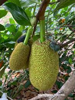

((75, 100), 100)

In [8]:
prev_im = Image.open(os.path.join(Orig_Dataset_path, current_source, current_image))
prev_im.thumbnail((100, 100))
display(prev_im)
max_dim = max(prev_im.size)
prev_im.size, max(prev_im.size)

Orig Image Dimensions -> Height: 100 Width: 75
Rotated Image Dimensions -> Height: 126 Width: 115
Old Coords of Bounding Box (Picture Focus Only): [(0, 0), (75, 0), (75, 100), (0, 100)]
New Coords After rotation: [(-19.975952641916447, 25.44872981077806), (44.97595264191645, -12.051270189221935), (94.97595264191645, 74.55127018922194), (30.024047358083546, 112.05127018922194)]
Excess Values (For Negative Fixes): -19.975952641916447 -12.051270189221935 94.97595264191645 112.05127018922194
19.975952641916447 13.948729810778062
Fixed Coords (Fixed Negative Values) [(0.0, 39.39745962155612), (64.9519052838329, 1.897459621556127), (114.9519052838329, 88.5), (49.99999999999999, 126.0)]


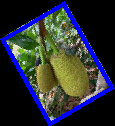

(115, 126)

In [9]:
x0 = 0
y0 = 0
x1 = prev_im.size[0]
y1 = prev_im.size[1]
image_width = prev_im.size[0]
image_height = prev_im.size[1]

degrees_ = 30
prev_im_copy = prev_im.copy()
prev_im_copy = prev_im_copy.rotate(degrees_, expand=True)
rot_im_width, rot_im_height = prev_im_copy.size

def calculate_new_x(degrees, x, y): return image_width / 2 + (x - image_width/2) * math.cos(degrees) + (y-image_height/2) * math.sin(degrees)
def calculate_new_y(degrees, x, y): return image_height / 2 - (x - image_width/2) * math.sin(degrees) + (y-image_height/2) * math.cos(degrees) 

degrees = math.radians(degrees_)

coords = [(x0, y0), (x1, y0), (x1, y1), (x0, y1)]
new_coords = []

smallest_x = 0
smallest_y = 0
largest_x = 1
largest_y = 1

for x, y in coords:
    _x = calculate_new_x(degrees, x, y)
    _y = calculate_new_y(degrees, x, y)
    new_coords.append((_x, _y))
    smallest_x = min(smallest_x, _x)
    smallest_y = min(smallest_y, _y)
    largest_x = max(largest_x, _x)
    largest_y = max(largest_y, _y)


fixed_coords = []


excess_x = 0 - smallest_x 
excess_y = rot_im_height - largest_y

print("Orig Image Dimensions -> Height:", image_height, "Width:", image_width)
print("Rotated Image Dimensions -> Height:", rot_im_height, "Width:", rot_im_width)
print("Old Coords of Bounding Box (Picture Focus Only):", coords)
print("New Coords After rotation:", new_coords)
print("Excess Values (For Negative Fixes):", smallest_x, smallest_y, largest_x, largest_y)
print(excess_x, excess_y)

for _x, _y in new_coords:
    fixed_coords.append((_x+excess_x, _y+excess_y))

print("Fixed Coords (Fixed Negative Values)", fixed_coords)



border_width = 5
d = ImageDraw.Draw(prev_im_copy)

# # d.line(new_coords, fill="red", width=border_width)
# # d.polygon(new_coords, width=border_width, outline="red")
d.polygon(fixed_coords, width=border_width, outline="blue")

display(prev_im_copy)
prev_im_copy.size

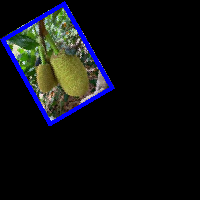

(17.0, 14.8)

In [10]:
target_x_variations = 5
target_y_variations = 5
canvas_size = (200, 200)
x_steps = abs(prev_im_copy.size[0] - canvas_size[0]) / target_x_variations
y_steps = abs(prev_im_copy.size[1] - canvas_size[1]) / target_y_variations
canvas = Image.new("RGB", canvas_size)
canvas.paste(prev_im_copy, (0, 0))
display(canvas)

x_steps, y_steps

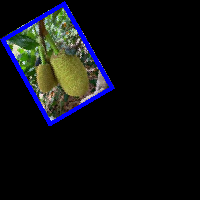

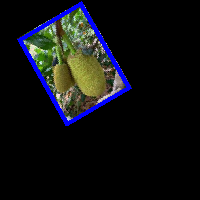

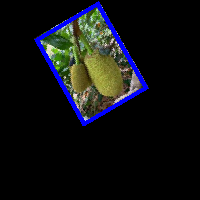

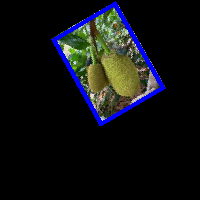

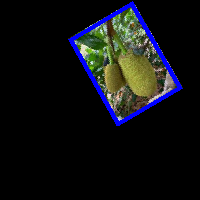

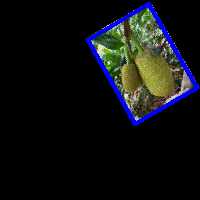

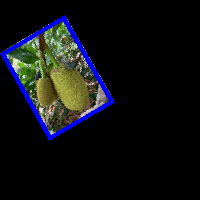

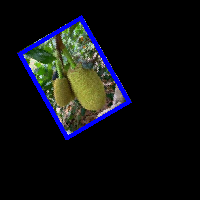

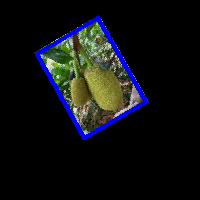

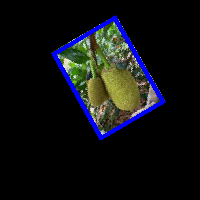

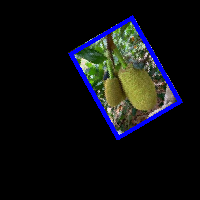

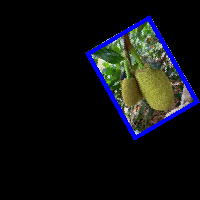

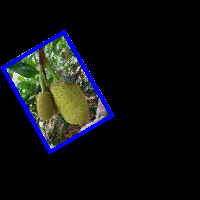

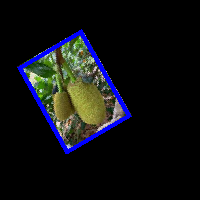

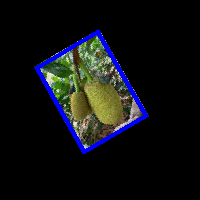

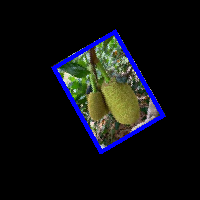

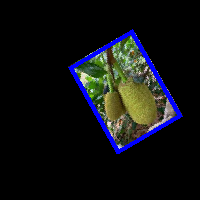

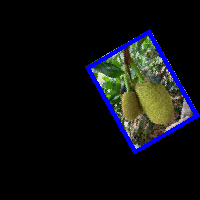

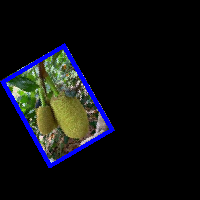

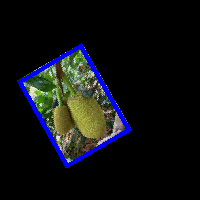

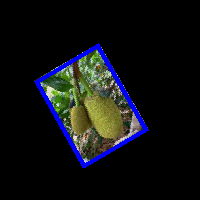

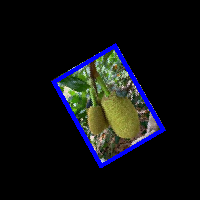

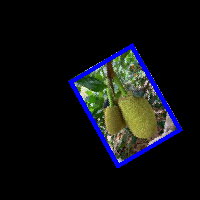

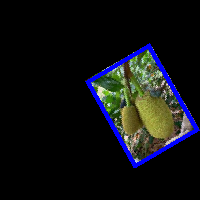

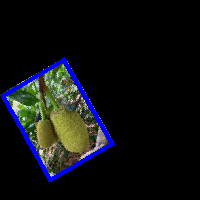

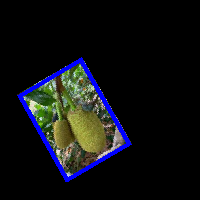

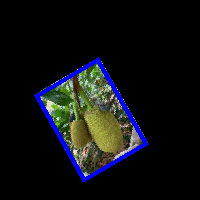

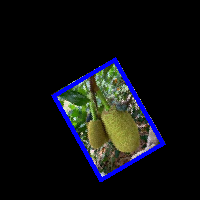

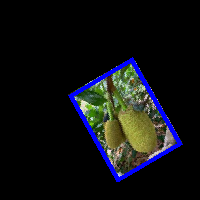

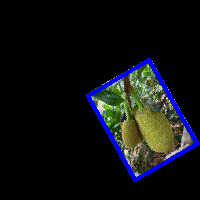

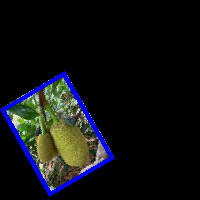

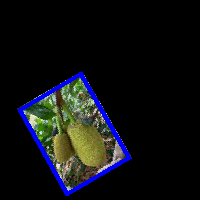

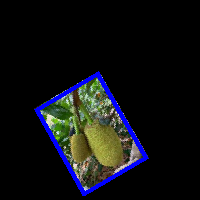

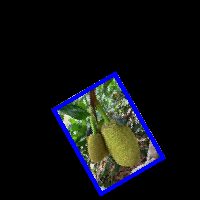

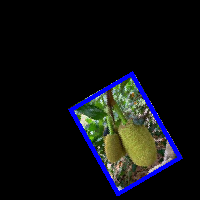

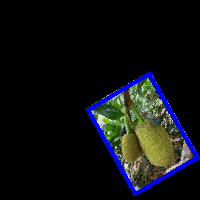

In [11]:
for y in range(target_y_variations + 1):
    for x in range(target_x_variations + 1):
        canvas2 = Image.new("RGB", canvas_size)
        canvas2.paste(prev_im_copy, (int(x_steps) * x, int(y_steps) * y))
        display(canvas2)

# x_variations * y_variations = 5 * 5 = 25
# angle diff = 10 -> 360 / 10 = 36 -> 36 * 25 = 900
# images per class = 50 * 900 = 45000
# number of classes = 10 * 45k = 450k        
